## Proyecto 2 - Predicción de Enfermedades Cardíacas
Juan Camilo Bello - 201820698

Nicolas Ricaurte - 201621525

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Cargamos los datos del archivo CSV
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
df = pd.read_csv(url, names=["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"], na_values='?')

#ver si cada columna tiene caracteres no numericos
df.apply(lambda x: sum(x.apply(type) == str), axis=0)
#Pasar todos los valores a numericos
df = df.apply(pd.to_numeric, errors='coerce')
#Eliminar las filas con valores nulos
df = df.dropna()
#Arreglar la columna num
df['num'] = df['num'].apply(lambda x: 0 if x == 0 else 1)

### Desarrollo Modelo Bayesiano

In [177]:
# Importamos las bibliotecas necesarias
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
import pandas as pd

# Creamos el modelo bayesiano
model = BayesianNetwork([('age', 'chol'), ('age', 'fbs'), ('age', 'trestbps'), ('sex', 'chol'),
                        ('sex', 'fbs'), ('sex', 'trestbps'), ('chol', 'num'), ('fbs', 'num'), ('trestbps', 'num'), 
                        ('num','exang'), ('num','cp')])

# Estimamos las distribuciones de probabilidad usando MLE
model.fit(df, estimator=MaximumLikelihoodEstimator)

# Estimamos las distribuciones de probabilidad usando MLE y BayesianEstimator
model.fit(df, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)

# Hacemos inferencias en el modelo bayesiano
from pgmpy.inference import VariableElimination

infer = VariableElimination(model)

# Ejemplo de inferencia para un paciente de 60 años, hombre, con dolor torácico tipo 2, presión arterial en reposo de 145, colesterol de 233, sin ayuno de azúcar en sangre,
# electrocardiograma en reposo normal, frecuencia cardíaca máxima alcanzada durante el ejercicio de 142, sin angina inducida por ejercicio, depresión del segmento ST de 2.4,
# pendiente del segmento ST de plano, 1 vaso sanguíneo coloreado por flourosopía y una Thal de 3
q = infer.query(['num'], evidence={'age': 29, 'sex': 1, 'cp': 1, 'trestbps': 100, 'chol': 200,'exang': 1,'fbs': 1})
print(q)


+--------+------------+
| num    |   phi(num) |
+========+============+
| num(0) |     0.3405 |
+--------+------------+
| num(1) |     0.6595 |
+--------+------------+


### Gráfica del modelo 

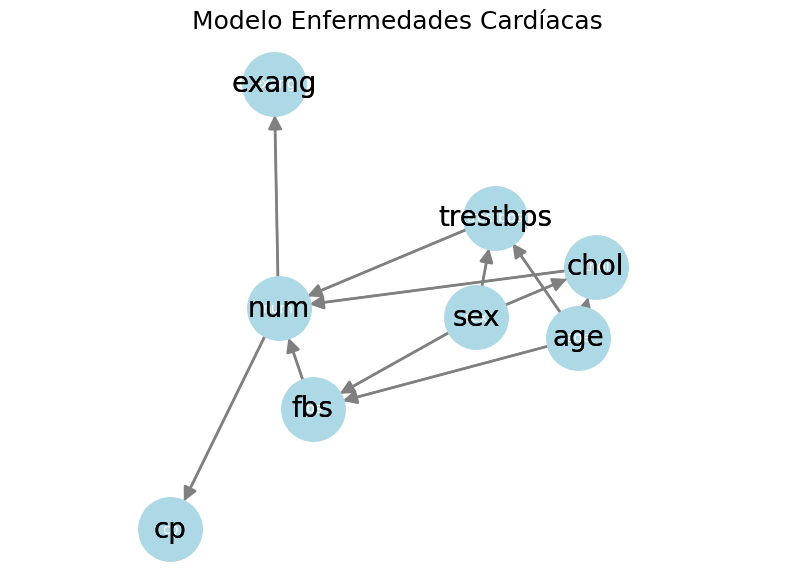

In [178]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Definición del DAG
nodes = ['age', 'chol', 'fbs', 'trestbps', 'sex', 'num', 'cp', 'exang']
edges = [('age', 'chol'), ('age', 'fbs'), ('age', 'trestbps'), ('sex', 'chol'),
                        ('sex', 'fbs'), ('sex', 'trestbps'), ('chol', 'num'), ('fbs', 'num'), ('trestbps', 'num'), 
                        ('num','exang'), ('num','cp')]

# Creación del grafo
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Configuración del estilo de visualización
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=0.5, seed=483902)

nx.draw_networkx_nodes(G, pos, node_size=700, node_color='green', edgecolors='black', linewidths=1.5)
nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes()}, font_size=10, font_color='white')
nx.draw_networkx_edges(G, pos, arrowsize=20, edge_color='gray', width=1.5, arrowstyle='->')

# Dibujar el grafo
nx.draw_networkx(G, pos, node_size=2000, node_color='lightblue', font_size=20, arrowsize=20, width=2, linewidths=2, edge_color='grey')

# Dibujar las etiquetas de los nodos
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')

# Establecer límites de zoom

plt.xlim(-0.7, 0.7)

# Mostrar la visualización del DAG
plt.title("Modelo Enfermedades Cardíacas", fontsize=18)
plt.axis('off')
plt.show()


# Proyecto 2 - Predicción de Enfermedades Cardíacas

### Desempeño del modelo bayesiano con los datos de entrenamiento

In [7]:
# Importamos las bibliotecas necesarias
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
import pandas as pd

# Cargamos los datos del archivo CSV
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
df = pd.read_csv(url, names=["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"], na_values='?')

# Dividir el dataframe en dos conjuntos de datos: entrenamiento y prueba
from sklearn.model_selection import train_test_split
train_og, test_og = train_test_split(df, test_size=0.2)

In [8]:
import numpy as np

# Eliminamos filas con valores faltantes
train = train_og.dropna()
test = test_og.dropna()

# Solo nos quedamos con las columnas que nos interesan age, sex, cp, trestbps, chol, fbs, exang, num
train = train.drop(columns=['restecg', 'thalach', 'oldpeak', 'slope', 'ca', 'thal'], axis=1)
test = test.drop(columns=['restecg', 'thalach', 'oldpeak', 'slope', 'ca', 'thal'], axis=1)

# Convertimos la columna de diagnóstico en un valor binario
train['num'] = train['num'].apply(lambda x: 0 if x == 0 else 1)
test['num'] = test['num'].apply(lambda x: 0 if x == 0 else 1)

# Identificar los valores faltantes en el train set
missing_values = {}
for column in train.columns:
    train_values = set(train[column].unique())
    test_values = set(test[column].unique())
    missing_values[column] = test_values - train_values

# Agregar filas al train set para cualquier valor faltante
for i, row in test.iterrows():
    if any(row[column] in missing_values[column] for column in missing_values):
        train = train.append(row)
        test = test.drop(i)

/var/folders/m6/xx2tl5h91wbf651lwjmb3f900000gn/T/ipykernel_5561/3463659797.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(row)
/var/folders/m6/xx2tl5h91wbf651lwjmb3f900000gn/T/ipykernel_5561/3463659797.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(row)
/var/folders/m6/xx2tl5h91wbf651lwjmb3f900000gn/T/ipykernel_5561/3463659797.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(row)
/var/folders/m6/xx2tl5h91wbf651lwjmb3f900000gn/T/ipykernel_5561/3463659797.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(row)
/var/folders/m6/xx2tl5h91wbf

In [9]:
# Creamos el modelo bayesiano
model = BayesianNetwork([('age', 'chol'), ('age', 'fbs'), ('age', 'trestbps'), ('sex', 'chol'),
                        ('sex', 'fbs'), ('sex', 'trestbps'), ('chol', 'num'), ('fbs', 'num'), ('trestbps', 'num'), 
                        ('num','exang'), ('num','cp')])

# Estimamos las distribuciones de probabilidad usando MLE
model.fit(train, estimator=MaximumLikelihoodEstimator)

# Estimamos las distribuciones de probabilidad usando MLE y BayesianEstimator
model.fit(train, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)

# Hacemos inferencias en el modelo bayesiano
from pgmpy.inference import VariableElimination

infer = VariableElimination(model)

In [10]:
# Hacer predicciones sobre los datos de prueba
predictions = []
for i in range(len(test)):
    evidence = {'age': test.iloc[i][0], 'sex': test.iloc[i][1], 'cp': test.iloc[i][2], 'trestbps': test.iloc[i][3], 'chol': test.iloc[i][4],'exang': test.iloc[i][5],'fbs': test.iloc[i][6]}
    prediction = infer.query(['num'], evidence=evidence)
    predictions.append(prediction)

# Convertir las predicciones a valores binarios
predictions_binary = [1 if prediction.values[1] > 0.5 else 0 for prediction in predictions]

# Convertir las etiquetas a una lista
labels = test['num'].tolist()

# Crear la matriz de confusión
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(labels, predictions_binary)

# tn: true negative, fp: false positive, fn: false negative, tp: true positive

# Calcular los porcentajes de verdaderos y falsos positivos y negativos
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / sum(cm.ravel())
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Specificity:", specificity)

Accuracy: 0.7352941176470589
Precision: 0.65
Recall: 0.8666666666666667
Specificity: 0.631578947368421


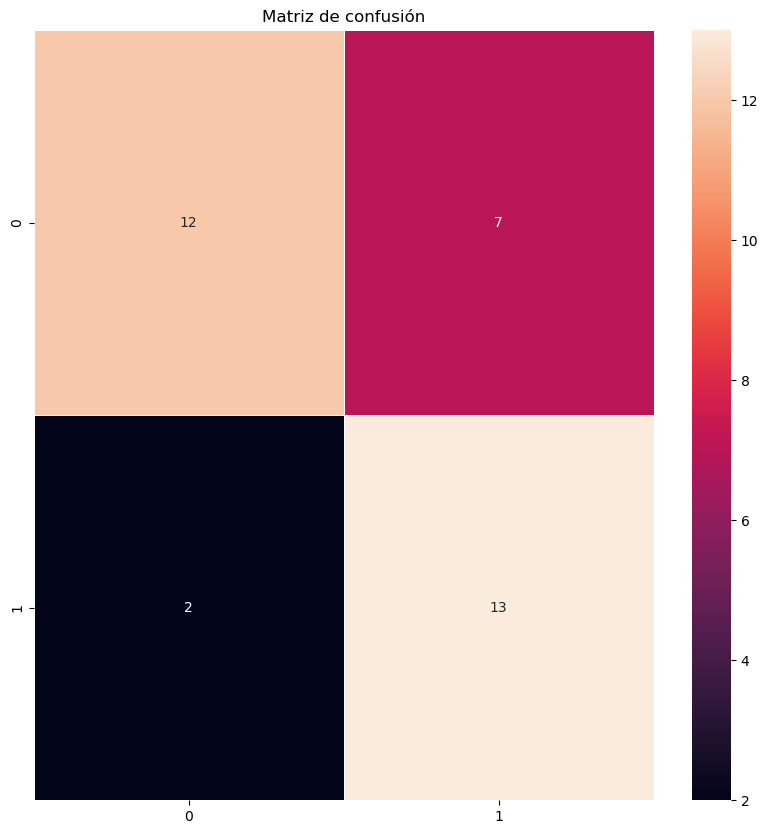

In [22]:
# mostrar la matriz de confusión
import seaborn as sns
import matplotlib.pyplot as plt

f,ax = plt.subplots(figsize=(10, 10))

sns.heatmap(cm, annot=True, linewidths=0.5, fmt= '.0f',ax=ax)
plt.title("Matriz de confusión")
plt.show()


In [11]:
from pgmpy.estimators import K2Score
scoring_method = K2Score(data=df)
# Un valor menor en el puntaje K2 indica un mejor ajuste del modelo a los datos
print(scoring_method.score(model))

-5076.176125915196


### Nuevo Modelo Bayesiano

In [40]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score

scoring_method = K2Score(data=df)
esth = HillClimbSearch(data=df)
new_model = esth.estimate(
    scoring_method=scoring_method,
    max_indegree=1,
    max_iter=int(1e6),
    black_list=(
        tuple(['age', 'sex']),
        tuple(['cp', 'sex']),
        tuple(['trestbps', 'sex']),
        tuple(['chol', 'sex']),
        tuple(['fbs', 'sex']),
        tuple(['restecg', 'sex']),
        tuple(['thalach', 'sex']),
        tuple(['exang', 'sex']),
        tuple(['oldpeak', 'sex']),
        tuple(['slope', 'sex']),
        tuple(['ca', 'sex']),
        tuple(['thal', 'sex']),
        tuple(['num', 'sex']),
        tuple(['sex', 'age']),
        tuple(['cp', 'age']),
        tuple(['trestbps', 'age']),
        tuple(['chol', 'age']),
        tuple(['fbs', 'age']),
        tuple(['restecg', 'age']),
        tuple(['thalach', 'age']),
        tuple(['exang', 'age']),
        tuple(['oldpeak', 'age']),
        tuple(['slope', 'age']),
        tuple(['ca', 'age']),
        tuple(['thal', 'age']),
        tuple(['num', 'age'])
    )
)

print(new_model)
print(new_model.nodes())
print(new_model.edges())

from pgmpy.estimators import K2Score
scoring_method = K2Score(data=df)
# Un valor menor en el puntaje K2 indica un mejor ajuste del modelo a los datos
print(scoring_method.score(new_model))

  0%|          | 0/1000000 [00:00<?, ?it/s]

DAG with 14 nodes and 9 edges
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
[('sex', 'thal'), ('cp', 'exang'), ('thalach', 'chol'), ('oldpeak', 'thalach'), ('slope', 'oldpeak'), ('thal', 'num'), ('num', 'ca'), ('num', 'cp'), ('num', 'slope')]
-8024.202007617752


In [43]:
# encontrar el mejor modelo que tenga el mejor score de K2
best_model = None
best_score = float('inf')
black_list = [ ['thal', 'sex'], ['age', 'sex'], ['sex', 'age'] ]
black_list = [tuple(edge) for edge in black_list]

for i in range(1, 13):
    new_model = esth.estimate(
    scoring_method=scoring_method,
    max_indegree=i,
    max_iter=int(1e6),
    black_list=black_list

)
    score = scoring_method.score(new_model)
    if score < best_score:
        best_model = new_model
        max_indegree = i
        best_score = score

print(best_model)
print(max_indegree)
print(best_score)
print(best_model.nodes())
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

DAG with 14 nodes and 9 edges
1
-8024.202007617752
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
[('sex', 'thal'), ('cp', 'exang'), ('thalach', 'chol'), ('oldpeak', 'thalach'), ('slope', 'oldpeak'), ('thal', 'num'), ('num', 'ca'), ('num', 'cp'), ('num', 'slope')]


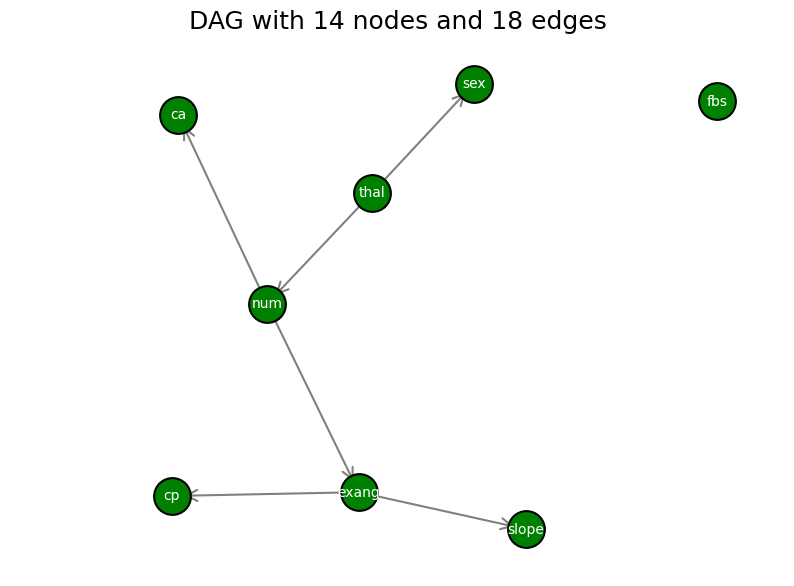

In [49]:
import networkx as nx
import matplotlib.pyplot as plt

# Definición del DAG
nodes = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
edges = [('exang', 'cp'), ('exang', 'slope'), ('thal', 'num'), ('thal', 'sex'), ('num', 'exang'), ('num', 'ca')]

# Creación del grafo
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Configuración del estilo de visualización
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=0.5, seed=10)

nx.draw_networkx_nodes(G, pos, node_size=700, node_color='green', edgecolors='black', linewidths=1.5)
nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes()}, font_size=10, font_color='white')
nx.draw_networkx_edges(G, pos, arrowsize=20, edge_color='gray', width=1.5, arrowstyle='->')

# Establecer límites de zoom

plt.xlim(-0.7, 0.7)

# Mostrar la visualización del DAG
plt.title("DAG with 14 nodes and 18 edges", fontsize=18)
plt.axis('off')
plt.show()

In [48]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore

scoring_method = BicScore(data=df)
esth = HillClimbSearch(data=df)
nuevo_modelo_BIC = esth.estimate(
    scoring_method=scoring_method, max_indegree=4, max_iter=int(1e6)
)
print(nuevo_modelo_BIC)
print(nuevo_modelo_BIC.nodes())
print(nuevo_modelo_BIC.edges())

scoring_method = K2Score(data=df)
print(scoring_method.score(nuevo_modelo_BIC))

  0%|          | 0/1000000 [00:00<?, ?it/s]

DAG with 14 nodes and 6 edges
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
[('exang', 'cp'), ('exang', 'slope'), ('thal', 'num'), ('thal', 'sex'), ('num', 'exang'), ('num', 'ca')]
-8145.201960033855
